<a href="https://colab.research.google.com/github/Alx-Lebeau/Cours-EcoElec/blob/main/notebooks/02_Equilibre_Long_Terme.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!rm -rf Cours-EcoElec
!git clone https://github.com/Alx-Lebeau/Cours-EcoElec.git
%cd Cours-EcoElec/notebooks
!ls


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pulp as pl
import config


Cloning into 'Cours-EcoElec'...
remote: Enumerating objects: 107, done.
remote: Counting objects: 100% (107/107), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 107 (delta 41), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (107/107), 1.55 MiB | 6.29 MiB/s, done.
Resolving deltas: 100% (41/41), done.
/content/Cours-EcoElec/notebooks
01_Equilibre_Court_Terme_correction.ipynb  config.py
01_Equilibre_Court_Terme_énoncé.ipynb	   Consommation_France_2024.csv
02_Equilibre_Long_Terme.ipynb		   Disponibilites_2024.csv


# Méthode des screening curves

Text(0.5, 0, "Nombre d'heure")

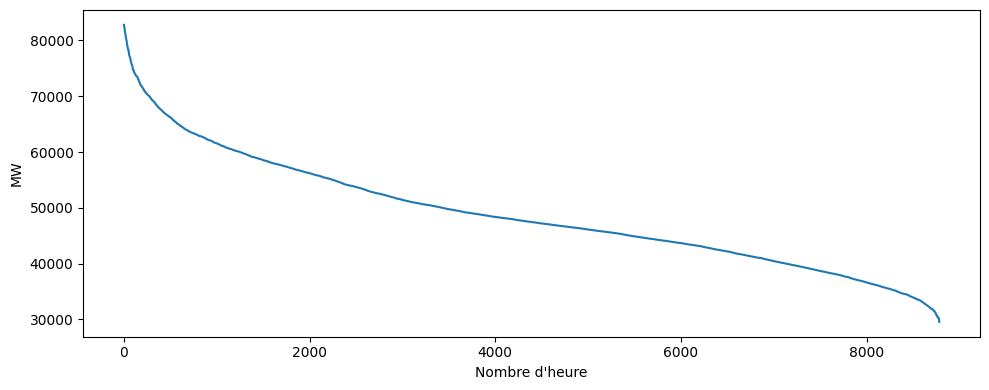

In [3]:

# Import des données
df = pd.read_csv("Consommation_France_2024.csv",index_col=0)
df["heure"] = pd.to_datetime(df["heure"])


# Visualisation de l'évolution annuelle de la consommation réalisée

fig, ax = plt.subplots(tight_layout=True,figsize =(10,4))

monotone = df["Consommation réalisée (MW)"].sort_values(ascending=False).values

ax.plot(monotone)

ax.set_ylabel("MW")
ax.set_xlabel("Nombre d'heure")


In [27]:
donnees_filieres = {
    "nucleaire": {"cout_variable": 10.0,
                  "cout_fixe": 200000.0},
    "gaz": {"cout_variable": 80.0,
            "cout_fixe": 90000}
}

(0.0, 500.0)

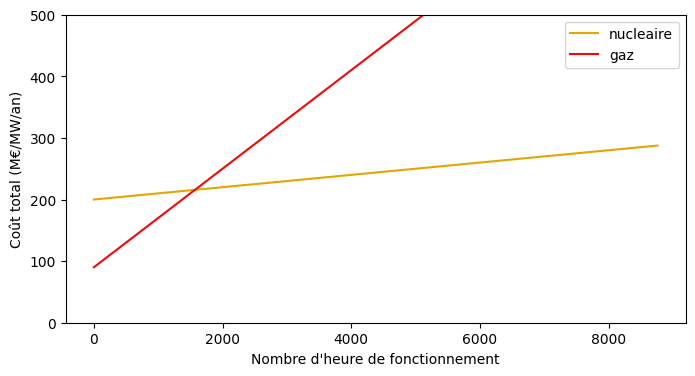

In [28]:
fig, ax = plt.subplots(figsize=(8,4))

t = np.arange(8760)

for i in donnees_filieres :

  cost_curve = donnees_filieres[i]["cout_fixe"] + donnees_filieres[i]["cout_variable"]*t
  ax.plot(cost_curve / 1000,
          label = i,
          color = config.couleurs[i])

ax.set_xlabel("Nombre d'heure de fonctionnement")
ax.set_ylabel("Coût total (M€/MW/an)")

ax.legend(loc="best")
ax.set_ylim([0,500])

In [51]:
capa_nuc = monotone[1571]
capa_total = monotone[3]
capa_gaz = capa_total - capa_nuc

print(capa_nuc, capa_gaz, capa_total)

58180.0 24302.0 82482.0


# Méthode optim

In [58]:
donnees_filieres = {
    "nucleaire": {"cout_variable": 10.0,
                  "cout_fixe": 200000.0},
    "gaz": {"cout_variable": 80.0,
            "cout_fixe": 90000}
}

In [59]:
demande = df["Consommation réalisée (MW)"].values

VOLL = 33000.0  # €/MWh

# ---- Ensembles ----
filieres = list(donnees_filieres.keys())
T = range(len(demande))

# ---- Modèle ----
modele = pl.LpProblem("Dispatch_Electrique_Court_Terme", pl.LpMinimize)


# ---- Variables de décision ----
# prod[i, t] = production de la filière i au temps t (MW)
prod = pl.LpVariable.dicts("prod", (filieres, T), lowBound=0)

# capacités
capa = pl.LpVariable.dicts("capa",(filieres),lowBound=0)


# END[t] = énergie non distribuée au temps t (MW)
END = pl.LpVariable.dicts("END", T, lowBound=0)

# ---- Objectif : minimiser le coût total ----

# 1) coût des filières de production
cout_production = pl.lpSum(
    prod[i][t] * donnees_filieres[i]["cout_variable"]
    for i in filieres
    for t in T
)


# 2) coût de l'énergie non distribuée
cout_END = pl.lpSum(
    END[t] * VOLL
    for t in T
)

# 3) coût d'investissement

cout_invest = pl.lpSum(
    capa[i] * donnees_filieres[i]["cout_fixe"]
    for i in filieres
)

# Objectif total = production + END
modele += cout_production + cout_END + cout_invest


for t in T:
    modele += (
        pl.lpSum(prod[i][t] for i in filieres) + END[t] == demande[t],
        f"Equilibre_t{t}"
    )


for i in filieres:
    for t in T:
        modele += (
            prod[i][t] <= capa[i],  #* df_dispo.loc[t][i],
            f"Capacite_{i}_t{t}"
        )



# ---- Résolution ----
modele.solve(pl.PULP_CBC_CMD(msg=False))

print("Statut :", pl.LpStatus[modele.status])
print("Coût total :", pl.value(modele.objective))
print("\t dont coût de production :", pl.value(cout_production))
print("\t dont coût de l'investissement :", pl.value(cout_invest))
print("\t dont coût de l'END :", pl.value(cout_END))


df_resultats_horaires = pd.DataFrame({
    "demande": demande,
    "END": [END[t].value() for t in T],
    "prix_marginal": [
        modele.constraints[f"Equilibre_t{t}"].pi for t in T
    ],
    **{
        f"prod_{i}": [prod[i][t].value() for t in T]
        for i in filieres
    }
})


df_capa = pd.DataFrame({
    "filiere": filieres,
    "capa_opt_MW": [capa[i].value() for i in filieres],
    "cout_fixe_EUR_par_MW": [donnees_filieres[i]["cout_fixe"] for i in filieres],
}).set_index("filiere")

# calcul des rentes inframarginales :


# Rentes inframarginales (EUR) sur l'horizon + par MW installé (EUR/MW)
df_capa["rente_inframarginale_EUR"] = pd.DataFrame(
    {i: df_resultats_horaires["prix_marginal"] - donnees_filieres[i]["cout_variable"] for i in filieres}
).mul(
    df_resultats_horaires[[f"prod_{i}" for i in filieres]].set_axis(filieres, axis=1)
).sum()

df_capa["rente_inframarginale_EUR_par_MW"] = df_capa["rente_inframarginale_EUR"] / df_capa["capa_opt_MW"]


Statut : Optimal
Coût total : 18850692453.6
	 dont coût de production : 5013166453.6
	 dont coût de l'investissement : 13825250000.0
	 dont coût de l'END : 12276000.0


In [60]:
df_capa

,capa_opt_MW,cout_fixe_EUR_par_MW,rente_inframarginale_EUR,rente_inframarginale_EUR_par_MW
filiere,,,,
nucleaire,58180.0,200000.0,1.163600e+10,200000.0
gaz,24325.0,90000.0,2.189250e+09,90000.0


# Avec les disponibilités

In [61]:

# Import des données
df_dispo = pd.read_csv("Disponibilites_2024.csv",index_col=0)
df_dispo["heure"] = pd.to_datetime(df_dispo["heure"])



In [66]:
donnees_filieres = {
    "nucleaire": {"cout_variable": 10.0,
                  "cout_fixe": 200000.0},
    "gaz": {"cout_variable": 80.0,
            "cout_fixe": 90000},
    "solaire": {"cout_variable": 0.0,
                 "cout_fixe":78000},
    "eolien": {"cout_variable": 0.0,
                 "cout_fixe":100000}
}

In [67]:
demande = df["Consommation réalisée (MW)"].values

VOLL = 33000.0  # €/MWh

# ---- Ensembles ----
filieres = list(donnees_filieres.keys())
T = range(len(demande))

# ---- Modèle ----
modele = pl.LpProblem("Dispatch_Electrique_Court_Terme", pl.LpMinimize)


# ---- Variables de décision ----
# prod[i, t] = production de la filière i au temps t (MW)
prod = pl.LpVariable.dicts("prod", (filieres, T), lowBound=0)

# capacités
capa = pl.LpVariable.dicts("capa",(filieres),lowBound=0)


# END[t] = énergie non distribuée au temps t (MW)
END = pl.LpVariable.dicts("END", T, lowBound=0)

# ---- Objectif : minimiser le coût total ----

# 1) coût des filières de production
cout_production = pl.lpSum(
    prod[i][t] * donnees_filieres[i]["cout_variable"]
    for i in filieres
    for t in T
)


# 2) coût de l'énergie non distribuée
cout_END = pl.lpSum(
    END[t] * VOLL
    for t in T
)

# 3) coût d'investissement

cout_invest = pl.lpSum(
    capa[i] * donnees_filieres[i]["cout_fixe"]
    for i in filieres
)

# Objectif total = production + END
modele += cout_production + cout_END + cout_invest


for t in T:
    modele += (
        pl.lpSum(prod[i][t] for i in filieres) + END[t] == demande[t],
        f"Equilibre_t{t}"
    )


for i in filieres:
    for t in T:
        modele += (
            prod[i][t] <= capa[i] * df_dispo.loc[t][i],
            f"Capacite_{i}_t{t}"
        )



# ---- Résolution ----
modele.solve(pl.PULP_CBC_CMD(msg=False))

print("Statut :", pl.LpStatus[modele.status])
print("Coût total :", pl.value(modele.objective))
print("\t dont coût de production :", pl.value(cout_production))
print("\t dont coût de l'investissement :", pl.value(cout_invest))
print("\t dont coût de l'END :", pl.value(cout_END))


df_resultats_horaires = pd.DataFrame({
    "demande": demande,
    "END": [END[t].value() for t in T],
    "prix_marginal": [
        modele.constraints[f"Equilibre_t{t}"].pi for t in T
    ],
    **{
        f"prod_{i}": [prod[i][t].value() for t in T]
        for i in filieres
    }
})


df_capa = pd.DataFrame({
    "filiere": filieres,
    "capa_opt_MW": [capa[i].value() for i in filieres],
    "cout_fixe_EUR_par_MW": [donnees_filieres[i]["cout_fixe"] for i in filieres],
}).set_index("filiere")

# calcul des rentes inframarginales :


# Rentes inframarginales (EUR) sur l'horizon + par MW installé (EUR/MW)
df_capa["rente_inframarginale_EUR"] = pd.DataFrame(
    {i: df_resultats_horaires["prix_marginal"] - donnees_filieres[i]["cout_variable"] for i in filieres}
).mul(
    df_resultats_horaires[[f"prod_{i}" for i in filieres]].set_axis(filieres, axis=1)
).sum()

df_capa["rente_inframarginale_EUR_par_MW"] = df_capa["rente_inframarginale_EUR"] / df_capa["capa_opt_MW"]


Statut : Optimal
Coût total : 21950420763.6
	 dont coût de production : 5361317763.6
	 dont coût de l'investissement : 16574550000.0
	 dont coût de l'END : 14553000.0


In [68]:
df_capa

,capa_opt_MW,cout_fixe_EUR_par_MW,rente_inframarginale_EUR,rente_inframarginale_EUR_par_MW
filiere,,,,
nucleaire,69386.25,200000.0,1.387725e+10,200000.0
gaz,29970.00,90000.0,2.697300e+09,90000.0
solaire,0.00,78000.0,0.000000e+00,NaN
eolien,0.00,100000.0,0.000000e+00,NaN
